In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx
import custom_networks
from solution_files_manager import SolutionFilesManager

In [2]:
import mosek

In [3]:
import os
folder = os.path.abspath(os.getcwd())

## Data processing

In [4]:
case = "case30"
case_type = 0
is_custom = False
net = custom_networks.get_case(case, case_type, is_custom)

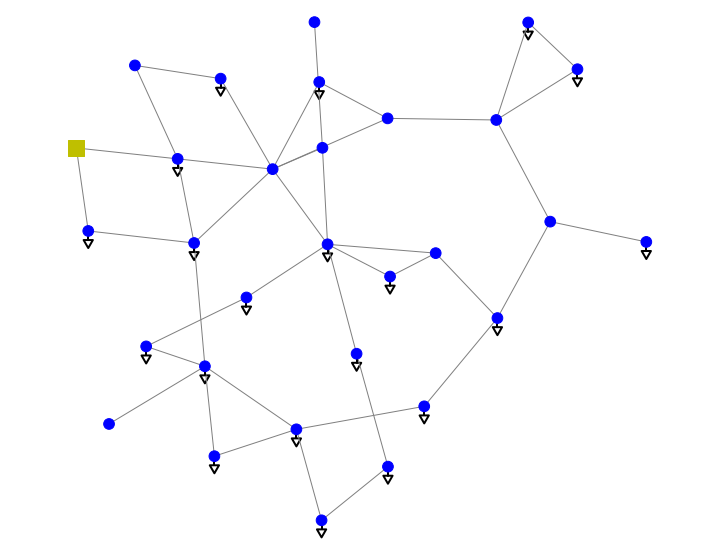

<AxesSubplot:>

In [5]:
simple_plot(net, plot_loads=True, plot_sgens=True)

In [6]:
n = len(net.bus)

In [7]:
# net.bus["max_vm_pu"] = np.ones((n,1))*1.05
# net.bus["min_vm_pu"] = np.ones((n,1))*0.99

#### Generators

In [8]:
gen_df_list = []
gen_name_list = ["ext_grid", "gen", "sgen"]
data_col_list = ["bus", "max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]

for gen_name in gen_name_list:
    if not net[gen_name].empty:
        # get a table of cost coefficients only for the current type of generators
        gen_name_poly_cost = net.poly_cost.loc[net.poly_cost.et == gen_name].set_index("element")
        # get a table of cost coefficients and power bounds only for the current type of generators
        gen_name_df = net[gen_name][data_col_list].join(gen_name_poly_cost)
        gen_df_list.append(gen_name_df)

# combine tables for all types of generators
gen_df = pd.concat(gen_df_list).reset_index()
n_gen = len(gen_df)

In [9]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,0,80.0,0.0,150.0,-20.0,ext_grid,0.0,2.00,0.02000,0.0,0.0,0.0
1,0,1,80.0,0.0,60.0,-20.0,gen,0.0,1.75,0.01750,0.0,0.0,0.0
2,1,21,50.0,0.0,62.5,-15.0,gen,0.0,1.00,0.06250,0.0,0.0,0.0
3,2,26,55.0,0.0,48.7,-15.0,gen,0.0,3.25,0.00834,0.0,0.0,0.0
4,3,22,30.0,0.0,40.0,-10.0,gen,0.0,3.00,0.02500,0.0,0.0,0.0
5,4,12,40.0,0.0,44.7,-15.0,gen,0.0,3.00,0.02500,0.0,0.0,0.0


#### Bus loads

In [10]:
load_df = net.bus.join(net.load[["bus", "p_mw", "q_mvar"]].set_index("bus")).fillna(0)[["p_mw", "q_mvar"]]

In [11]:
load_df

,p_mw,q_mvar
0,0.0,0.0
1,21.7,12.7
2,2.4,1.2
3,7.6,1.6
4,0.0,0.0
5,0.0,0.0
6,22.8,10.9
7,30.0,30.0
8,0.0,0.0
9,5.8,2.0


#### Admittance matrices

In [12]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

In [13]:
# compute non-diagonal entries of the admittance matrices (opposite of mutual admittance on each line)
G_val = np.zeros((n,n))
B_val = np.zeros((n,n))
for i,j in graph.edges:
    edge = graph.edges[(i,j)]
    r = edge["r_pu"]
    x = edge["x_pu"]
    z = r + x*1j
    y = np.reciprocal(z)
    G_val[i][j] = G_val[j][i] = -np.real(y)
    B_val[i][j] = B_val[j][i] = -np.imag(y)

In [14]:
# compute line susceptance in p.u.
net.line['s_pu'] = net.line['c_nf_per_km'] * net.line["length_km"] * (2 * np.pi * net.f_hz) * \
    ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2) / net.sn_mva / net.line['parallel'] / 1e9

In [15]:
# compute intermediate values that will sum to the diagonal entries of G and B
G_interm = -np.copy(G_val)
B_interm = -np.copy(B_val)
# add line susceptance
for _, row in net.line.iterrows():
    B_interm[row["from_bus"]][row["to_bus"]] += row["s_pu"] / 2
    B_interm[row["to_bus"]][row["from_bus"]] += row["s_pu"] / 2
# transformers
for _, row in net.trafo.iterrows():
    h = row["hv_bus"]
    l = row["lv_bus"]
    ratio_magnitude = (row["vn_hv_kv"] / row["vn_lv_kv"]) * (net.bus.loc[l]["vn_kv"] / net.bus.loc[h]["vn_kv"])
    ratio_sq = ratio_magnitude**2
    G_interm[h][l] /= ratio_sq
    B_interm[h][l] /= ratio_sq
    G_interm[l][h] *= ratio_sq
    B_interm[l][h] *= ratio_sq
    # shift degrees
    # FIXME
    if row["tap_phase_shifter"]:
        theta = row["shift_degree"]
        ratios_denom = np.exp(-1j * (2 * theta / 180 * np.pi))
        G_val[h][l] /= ratios_denom
        B_val[h][l] /= ratios_denom
        G_val[l][h] *= ratios_denom
        B_val[l][h] *= ratios_denom
    
G_row_sums = np.sum(G_interm, axis=1)
B_row_sums = np.sum(B_interm, axis=1)
for i in range(n):
    shunt_row = net.shunt.loc[net.shunt["bus"] == i]
    g = 0  # shunt conductance
    b = 0  # shunt susceptance
    # if both are 0, there will be no data in the shunt dataframe
    if not shunt_row.empty:
        g = shunt_row["p_mw"] / net.sn_mva
        b = -shunt_row["q_mvar"] / net.sn_mva
    G_val[i][i] = g + G_row_sums[i]
    B_val[i][i] = b + B_row_sums[i]

## Variables

In [16]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [17]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [18]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [19]:
# vectors of cost coefficients: c_[p or q]_[power]

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

## Constraints

### SOCP

In [20]:
constraints = [ cp.quad_over_lin(cp.norm(X[i][j]), cp.real(X[i][i])) <= cp.real(X[j][j]) for i,j in graph.edges]

### SDP

In [21]:
constraints = [X >> 0]

In [22]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

In [23]:
constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [24]:
# constraints += [ X[0][0] == 1 ]

In [25]:
constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

## Solving

In [26]:
p_cost = cp.sum(c_p_2 @ cp.square(p_g) + c_p_1 @ p_g + cp.sum(c_p_0))
q_cost = cp.sum(c_q_2 @ cp.square(q_g) + c_q_1 @ q_g + cp.sum(c_q_0))

In [27]:
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

In [28]:
prob.is_dcp()

True

In [29]:
prob.is_dpp()

True

In [30]:
# prob.solve(solver=cp.SCS)  # eps=1e-6
# prob.solve(solver=cp.CVXOPT, verbose=True)
prob.solve(solver=cp.MOSEK, mosek_params={mosek.iparam.intpnt_solve_form : mosek.solveform.dual})

# Print result.
print("The optimal value is", prob.value)
# print("A solution X is")
# print(X.value)

The optimal value is 574.5167294117241


In [31]:
np.linalg.matrix_rank(X.value, tol=1e-2)

2

In [32]:
np.linalg.matrix_rank(constraints[0].dual_value, tol=1e-2)

28

In [33]:
np.linalg.eigvalsh(X.value)

array([-1.65103401e-09, -1.62999438e-09, -1.58778767e-09, -1.55079030e-09,
       -1.51845395e-09, -1.49097507e-09, -1.45191260e-09, -1.41736191e-09,
       -1.39203358e-09, -1.35982393e-09, -1.30127121e-09, -1.23010355e-09,
       -1.19505502e-09, -1.14913429e-09, -1.12592042e-09, -8.67766434e-10,
       -7.20621662e-10, -6.53929506e-10, -5.05704160e-10, -2.68360603e-10,
       -8.96188940e-11,  4.87790565e-10,  1.98351923e-09,  4.34818818e-09,
        6.62563500e-09,  5.70506540e-08,  6.98420954e-08,  1.45183802e-07,
        1.48076847e-02,  3.23225820e+01])

In [34]:
np.linalg.eigvalsh(constraints[0].dual_value)

array([8.19337425e-08, 3.88348355e-05, 1.48667951e+00, 5.05842178e+00,
       2.92852907e+01, 3.75651617e+01, 1.53174343e+02, 2.14478060e+02,
       2.60852068e+02, 4.03266967e+02, 4.68950714e+02, 5.08614168e+02,
       5.33784188e+02, 5.76434629e+02, 6.82408765e+02, 9.31897945e+02,
       1.02603905e+03, 1.05479377e+03, 1.22397166e+03, 1.40321629e+03,
       1.54851838e+03, 1.60640823e+03, 1.70646120e+03, 2.33049559e+03,
       2.43474853e+03, 2.69964061e+03, 3.23389192e+03, 3.53491497e+03,
       5.65291425e+03, 8.85458187e+03])

In [35]:
np.diag(constraints[0].dual_value)

array([1.18236202e+03-4.18474244e-06j, 1.83066868e+03-3.34028695e-06j,
       1.39516668e+03+7.04347065e-07j, 2.66260297e+03-8.45343815e-10j,
       8.01759031e+02+5.48708576e-07j, 4.46548557e+03-6.15227707e-06j,
       1.40660923e+03-1.70478143e-06j, 1.47174453e+03-1.41533793e-06j,
       2.71813147e+01+1.00034071e-08j, 2.71305987e+03+5.89420716e-06j,
       6.95324964e+00+1.83066849e-09j, 1.26686194e+03+3.94635188e-06j,
       3.74371272e-05-8.07353406e-12j, 7.78228124e+02-2.49465460e-07j,
       1.87030109e+03+3.60764363e-07j, 7.44113623e+02+1.19553791e-07j,
       1.20395396e+03+7.44205613e-08j, 9.59650830e+02-5.03706623e-08j,
       1.65577342e+03-7.76131163e-07j, 1.40316844e+03+1.64657248e-07j,
       4.94210927e+03+2.85572451e-06j, 4.87836611e+03+5.06943417e-05j,
       6.62040129e+02+1.01115831e-07j, 1.04588967e+03+5.40666289e-09j,
       8.65610723e+02+4.37842445e-08j, 2.40795917e+02-3.80484907e-08j,
       6.88284299e+02+9.90290131e-07j, 1.24964280e+03+1.03356957e-06j,
      

In [36]:
np.trace(X.value @ constraints[0].dual_value)

(-4.600923645993503e-05+2.819554485722353e-12j)

In [37]:
# recover V by diagonalization
(eigen_val, eigen_vec) = np.linalg.eigh(X.value)
V = np.sqrt(eigen_val[n-1]) * eigen_vec[:,n-1]

# V * np.conj(V.reshape(-1,1))

In [38]:
print(p_g.value)
print(q_g.value)

[[0.43793106]
 [0.5796418 ]
 [0.23073821]
 [0.32632296]
 [0.1681034 ]
 [0.17345618]]
[[-0.01088436]
 [ 0.22879349]
 [ 0.28936191]
 [ 0.14377889]
 [ 0.07050494]
 [ 0.37713261]]


In [39]:
prob.status

'optimal'

In [40]:
# sfm = SolutionFilesManager(folder, case, case_type, "sdp")
# sfm.save_solution(prob.value, X, p_g, q_g)

### Iterations

In [41]:
# for i in range(n):
#     constraints += [ cp.real(X[i][i]) <= 1.02 * cp.real(X.value[i][i]), cp.real(X[i][i]) >= 0.98 * cp.real(X.value[i][i]) ]

In [42]:
# Y = cp.Parameter((n,n), hermitian=True, value=X.value)
# prod = cp.trace((np.eye(n) * cp.conj(Y)) @ (np.eye(n) * X))
# prob = cp.Problem(cp.Maximize(cp.real(prod)), constraints)

In [43]:
# prob.solve()

In [44]:
# np.linalg.norm(X.value - Y.value)

In [45]:
# np.abs(np.linalg.eigvalsh(X.value))

### Verify constraints with original solution

In [46]:
sfm = SolutionFilesManager(folder, case, case_type, "orig")
_, V_orig, p_orig, q_orig = sfm.load_solution()

In [47]:
X_orig = V_orig @ V_orig.conjugate().reshape(1,-1)
# print(X_orig)

In [48]:
print(p_orig)
print(q_orig)

[[0.39448512]
 [0.531028  ]
 [0.22382039]
 [0.46459464]
 [0.15473338]
 [0.15125194]]
[[-0.19949941]
 [ 0.18177125]
 [ 0.35696561]
 [ 0.226085  ]
 [ 0.04753351]
 [ 0.43047716]]


In [49]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print("active %d"  %(i))
    print(np.sum([p_orig[k] for k in gen_list]) - p_d_val[i])
    print(G_val[i][i] * X_orig[i][i] + np.sum([G_val[i][j] * np.real(X_orig[i][j]) + B_val[i][j] * np.imag(X_orig[i][j]) for j in graph.neighbors(i)]))
    print("reactive %d"  %(i))
    print(np.sum([q_orig[k] for k in gen_list]) - q_d_val[i])
    print(-B_val[i][i] * X_orig[i][i] + np.sum([-B_val[i][j] * np.real(X_orig[i][j]) + G_val[i][j] * np.imag(X_orig[i][j]) for j in graph.neighbors(i)]))

active 0
[0.39448512]
(0.39448525023857073+0j)
reactive 0
[-0.19949941]
(-0.19949942348040395+0j)
active 1
[0.314028]
(0.3140280628538168+0j)
reactive 1
[0.05477125]
(0.05477142296406967+0j)
active 2
[-0.024]
(-0.02399994251335258+0j)
reactive 2
[-0.012]
(-0.01200000112834232+0j)
active 3
[-0.076]
(-0.07599980605498402+0j)
reactive 3
[-0.016]
(-0.01599990797967621+0j)
active 4
[0.]
(1.5803633957034435e-09+0j)
reactive 4
[0.]
(-7.020748427066792e-10+0j)
active 5
[0.]
(6.553699805067481e-08+0j)
reactive 5
[0.]
(-3.5172291745766415e-09+0j)
active 6
[-0.228]
(-0.22799998667643884+0j)
reactive 6
[-0.109]
(-0.10899999997358734+0j)
active 7
[-0.3]
(-0.2999999826648443+0j)
reactive 7
[-0.3]
(-0.2999999948363907+0j)
active 8
[0.]
(2.5623875840596888e-08+0j)
reactive 8
[0.]
(8.56828208384286e-09+0j)
active 9
[-0.058]
(-0.057999787380406786+0j)
reactive 9
[-0.02]
(-0.020000020303974964+0j)
active 10
[0.]
0j
reactive 10
[0.]
0j
active 11
[-0.112]
(-0.11200022885661909+0j)
reactive 11
[-0.075]
(-0.